# Problem 1 Introduction

1a. Sneha Kelkar, sgk18001                    
1b. In this notebook we are using AI to diagnose patients with heart diseases. In the latter part of the notebook, we are comparing differentt ypes of AI algorithms and talk about a common shortcoming of tree-based models:overfitting.
Additioanlly, we will discuess how newer models have attempted to deal with this issue.

#### 1c. Methods

1. The Heart Risk: An index that combines various factors that contribute to heart disease into a single metric. By incorporting multiple dimensions of heart health into one composite score, it offers a mosre holistic assement of an individual's risk of heart disease. This can be particularly useful in models where the interplay between different risk factors significaly impacts the outcome

Exercise tolerance: measured through metrics like the maximum heart rate achieved and the presence of exercise-induced angina, exercise tolerance is a strong indicator of cardiovascular health. A composite score that encapsulates these aspects provides a direct measure of an individual's physical fitness level and their heart's ability to handle physical stress.

2. As described above, mean-median data to impute missing data.
3. We will split the data into train and test. We will scale the continuous variables and then split the test to validation and test for optimization
4. We will utilize a custom gridsearch algorithm that will allow us to optimize on the validation data instead of the training data to ensure the ability to generalize
5. inally, we will use a K-fold cross-validation  splitting strategy to see how these models will perform on the test set

In [38]:
#---------------------------------------------------------------------------------------------
#load the libraries that are required for this project:
#---------------------------------------------------------------------------------------------
import numpy as np              # NumPy is for numerical operations
import pandas as pd             # Pandas is for data analysis and structure manipulation
import matplotlib               # MatPlotLib is for making plots & figures
import matplotlib.pyplot as plt # PyPlot is a subset of the library for making MATLAB-style plots

## Data Cleaning

#### 1. Loading in the datasets and concatenating them together

In [39]:
cleveland_df = pd.read_csv('cleveland.csv')
hungary_df = pd.read_csv('hungarian.csv')
switzerland = pd.read_csv('switzerland.csv')
va_df = pd.read_csv('va.csv')

df = pd.concat([cleveland_df, hungary_df, switzerland, va_df], ignore_index=True)


#### 2. Inspecting the Data Types and Checking for missing values

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       920 non-null    int64  
 1   sex       920 non-null    int64  
 2   cp        920 non-null    int64  
 3   trestbps  862 non-null    float64
 4   chol      913 non-null    float64
 5   fbs       913 non-null    object 
 6   restecg   919 non-null    float64
 7   thalach   866 non-null    float64
 8   exang     866 non-null    float64
 9   oldpeak   858 non-null    float64
 10  slope     801 non-null    float64
 11  ca        916 non-null    object 
 12  thal      866 non-null    object 
 13  num       920 non-null    int64  
dtypes: float64(7), int64(4), object(3)
memory usage: 100.8+ KB


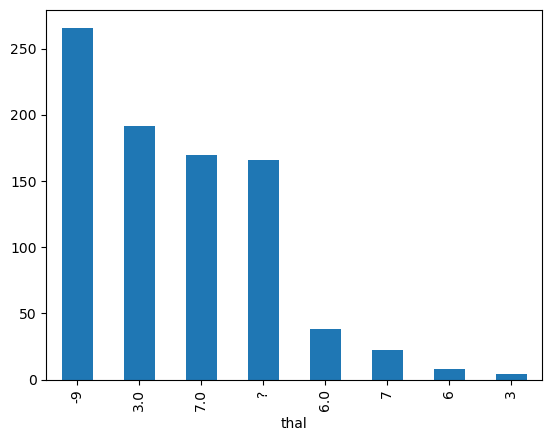

In [41]:
#looking at the "Thal" column further

df['thal'].value_counts().plot(kind='bar')
plt.show()

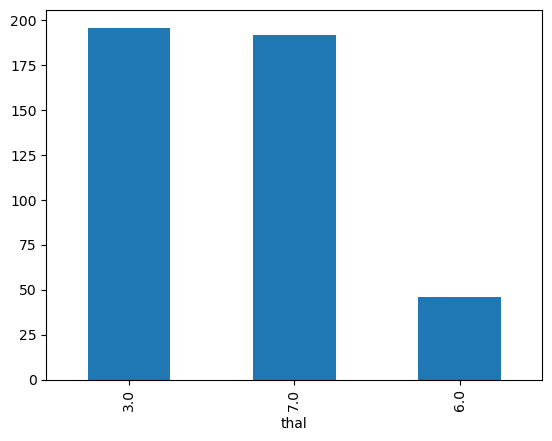

In [42]:
#Standardizing the values such that 3.0 = 3 and ? = -9 as specified in the instructions
df['thal'] = df['thal'].replace(to_replace=[-9, '?'], value=np.NaN).astype(np.float32)
df['thal'].value_counts().plot(kind='bar')
plt.show()

In [43]:
#Iterate over the columns with an operation to replace missing values
for column in df.columns:
    df[column] = df[column].replace(to_replace=[-9, '?', 'NaN'], value=np.NaN)

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       920 non-null    int64  
 1   sex       920 non-null    int64  
 2   cp        920 non-null    int64  
 3   trestbps  861 non-null    float64
 4   chol      890 non-null    float64
 5   fbs       830 non-null    object 
 6   restecg   918 non-null    float64
 7   thalach   865 non-null    float64
 8   exang     865 non-null    float64
 9   oldpeak   858 non-null    float64
 10  slope     611 non-null    float64
 11  ca        310 non-null    object 
 12  thal      434 non-null    float32
 13  num       920 non-null    int64  
dtypes: float32(1), float64(7), int64(4), object(2)
memory usage: 97.2+ KB


In [45]:
# A lot of these columns have missing values so they will need to be cleaned up
#in the same way
#----------------------------------------------------------------------------------------
for column in df.columns:
    print(f' {column} : {df[column].unique()}')

 age : [63 67 37 41 56 62 57 53 44 52 48 54 49 64 58 60 50 66 43 40 69 59 42 55
 61 65 71 51 46 45 39 68 47 34 35 29 70 77 38 74 76 36 32 31 33 28 30 72
 73 75]
 sex : [1 0]
 cp : [1 4 3 2]
 trestbps : [145. 160. 120. 130. 140. 172. 150. 110. 132. 117. 135. 112. 105. 124.
 125. 142. 128. 170. 155. 104. 180. 138. 108. 134. 122. 115. 118. 100.
 200.  94. 165. 102. 152. 101. 126. 174. 148. 178. 158. 192. 129. 144.
 123. 136. 146. 106. 156. 154. 114. 164. 113. 190.  92.  98.  nan  95.
  80. 185. 116.   0.  96. 127.]
 chol : [233. 286. 229. 250. 204. 236. 268. 354. 254. 203. 192. 294. 256. 263.
 199. 168. 239. 275. 266. 211. 283. 284. 224. 206. 219. 340. 226. 247.
 167. 230. 335. 234. 177. 276. 353. 243. 225. 302. 212. 330. 175. 417.
 197. 198. 290. 253. 172. 273. 213. 305. 216. 304. 188. 282. 185. 232.
 326. 231. 269. 267. 248. 360. 258. 308. 245. 270. 208. 264. 321. 274.
 325. 235. 257. 164. 141. 252. 255. 201. 222. 260. 182. 303. 265. 309.
 307. 249. 186. 341. 183. 407. 217. 288. 220. 20

In [46]:
df['fbs'] = df['fbs'].replace(to_replace=['0', '1'],value =  [0, 1])
df['ca'] = df['ca'].replace(to_replace=['0', '1', '2', 9],value = [0, 1, 2, np.NaN])

### Creating two new Features: 'Heart_Risk_Index' and 'Exercise_Tolerance_Score'

New Feature 1: Heart Risk Index "heart_rate_index" which combines several indicators associated with a higher risk of heart disease, is calculated as the product of the patient's age divided by their maximum heart rate achieved (thalach) and the number of major vessels colored by fluoroscopy (ca)

New Feature 2: Exercise Tolerance Score 'exercise_tolerance_score' is derived from the ST depression induced by exercise relative to rest (oldpeak) multiplied by the increment of exercise-induced angina (exang + 1).

In [47]:
df['heart_risk_index'] = (df['age'] / df['thalach']) * df['ca'].astype(float)
df['exercise_tolerance_score'] = df['oldpeak'] * (df['exang'] + 1)

### Scaling and Imputing Missing Values

Here, split the data to train and test (and validation later). We Scale the data. Then, we will implement an imputation technique for missing values with median/mean imputation. It does so by finding the nearest neighbor(s) by using the mean and median as metrics.Then, it computes the average value of the desired imputed value .This process is repeated for each feature that has missing values. We can tune the n_neighbors parameter later

In [48]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

n_neighbors = 15
# Assuming 'df' is your DataFrame and 'target' is the target variable
X = df.drop('num', axis=1)
y = df['num']
continuous_cols = ['oldpeak', 'thalach', 'chol', 'trestbps', 'age', 'exercise_tolerance_score']
categorical_cols = [col for col in X.columns if col not in continuous_cols]

# Define the stratified shuffle split
split_info = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_index, test_index in split_info.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Scale the data
scaler = StandardScaler()
X_train_continuous = scaler.fit_transform(X_train[continuous_cols])
X_test_continuous = scaler.transform(X_test[continuous_cols])

X_train_scaled = np.hstack((X_train_continuous, X_train[categorical_cols]))
X_test_scaled = np.hstack((X_test_continuous, X_test[categorical_cols]))

# Standardize using median value for all values and missing values (based off of Practice 03)
imputer = SimpleImputer(strategy='median')
X_train_scaled = imputer.fit_transform(X_train_scaled)
X_test_scaled = imputer.transform(X_test_scaled)

print('Done')

Done


## Model Training

In [49]:
#necessary imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

### Random Forest:

Here we implement a custom grid search where we optimize on the validation data and see the final result on the test data

In [50]:
# Hyper-parameter grid
param_grid_rf = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'max_features': [None, 'sqrt', 'log2'],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy', 'log_loss']
}

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1), param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)

grid_search_rf.fit(X_train_scaled, y_train)
best_params = grid_search_rf.best_params_
best_score = grid_search_rf.best_score_
# Print the best parameters and their score on the validation set
print("Best parameters for Random Forest:", best_params)
print("Best score on the validation set for Random Forest:", best_score)
# Now you can retrain your model on the full training set with the best parameters
rf_best = RandomForestClassifier(**best_params, random_state=42)
rf_best.fit(X_train_scaled, y_train)

y_pred = rf_best.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the test set: {test_accuracy:.4f}")

print('Done')

Best parameters for Random Forest: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_split': 5, 'n_estimators': 50}
Best score on the validation set for Random Forest: 0.5512718023255814
Accuracy on the test set: 0.5326
Done


### Decision Trees with Boosting (AdaBoost)

In [51]:
param_grid_adaboost = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
    'estimator__max_depth': [1, 2, 3],
    'algorithm':['SAMME']
}
base_estimator = DecisionTreeClassifier()
estimator = AdaBoostClassifier(estimator=base_estimator)
grid_search_ada = GridSearchCV(estimator=estimator, param_grid=param_grid_adaboost, scoring='accuracy', cv=5)

grid_search_ada.fit(X_train_scaled, y_train)

best_params_adaboost = grid_search_ada.best_params_
best_score_adaboost = grid_search_ada.best_score_
# Print the best parameters and their score on the validation set
print("Best parameters for AdaBoost:", best_params_adaboost)
print("Best score on the validation set for AdaBoost:", best_score_adaboost)

best_model = DecisionTreeClassifier(max_depth = best_params_adaboost['estimator__max_depth'])
best_model = AdaBoostClassifier(estimator = best_model, n_estimators = best_params_adaboost['n_estimators'], learning_rate = best_params_adaboost['learning_rate'], random_state=42, algorithm='SAMME')
best_model.fit(X_train_scaled, y_train)

y_pred = best_model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the test set: {test_accuracy:.4f}")

Best parameters for AdaBoost: {'algorithm': 'SAMME', 'estimator__max_depth': 3, 'learning_rate': 0.01, 'n_estimators': 200}
Best score on the validation set for AdaBoost: 0.5434714147286821
Accuracy on the test set: 0.5399


### Decision Trees with Bagging:

In [52]:
# Hyper-parameter grid for Bagging
param_grid_bagging = {
    'n_estimators': [10, 20, 50, 100, 150],
    'estimator__max_depth': [None, 10, 20, 30, 40],
    'bootstrap' :[True, False],
}
base_estimator = DecisionTreeClassifier(random_state = 42)
estimator = BaggingClassifier(base_estimator)
grid_search_bagging = GridSearchCV(estimator, param_grid = param_grid_bagging, cv=5, scoring='accuracy',
                                   n_jobs = -1)

grid_search_bagging.fit(X_train_scaled, y_train)
best_params_bagging = grid_search_bagging.best_params_
best_score_bagging = grid_search_bagging.best_score_

print("Best parameters for Bagging:", best_params_bagging)
print("Best score on the validation set for Bagging:", best_score_bagging)

base_estimator = DecisionTreeClassifier(max_depth = best_params_bagging['estimator__max_depth'])
best_model = BaggingClassifier(base_estimator,n_estimators=best_params_bagging['n_estimators'], random_state=42)
best_model.fit(X_train_scaled, y_train)

y_pred = best_model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the test set: {test_accuracy:.4f}")

Best parameters for Bagging: {'bootstrap': True, 'estimator__max_depth': 10, 'n_estimators': 100}
Best score on the validation set for Bagging: 0.5388323643410853
Accuracy on the test set: 0.5217


## 1d. Results

To summarize, these models, show good potential to produce impressive results.
Having said that, the models still seem to overfit. To deal with the overfitting problem that tree models usually face, we added elements such as training multiple trees (random forest), or learning from previous mistakes (boosting), or finally, bootstrapping the data to reduce overfitting (bagging). 